In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)
import matplotlib.pyplot as plt
import warnings

# Ignore deprecation warnings for cleaner output
warnings.filterwarnings("ignore", category=DeprecationWarning)

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Setting Jedha color palette as default for Plotly
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=[
        "#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"
    ]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"

In [21]:
# Import dataset
print("Loading dataset...")
dataset = pd.read_csv("src/Data.csv")
print("Dataset loaded successfully.")
print(f"Shape of dataset: {dataset.shape}")
print("First 5 rows:")
print(dataset.head())
print()

Loading dataset...
Dataset loaded successfully.
Shape of dataset: (10, 4)
First 5 rows:
   Country   Age  Salary Purchased
0   France  44.0   72000        No
1    Spain  27.0   48000       Yes
2  Germany  30.0   54000        No
3    Spain  38.0   61000        No
4  Germany  40.0   69000       Yes



In [22]:
# Basic statistics and dataset overview
print("Dataset Overview:")
print(f"Number of rows: {dataset.shape[0]}")
print(f"Number of columns: {dataset.shape[1]}")
print()

# Display first few rows of the dataset
print("Preview of the dataset:")
display(dataset.head())
print()

# Basic statistics
print("Basic statistics for numerical and categorical columns:")
data_desc = dataset.describe(include="all")
display(data_desc)
print()

# Percentage of missing values for each column
print("Percentage of missing values in each column:")
missing_values = 100 * dataset.isnull().sum() / dataset.shape[0]
display(missing_values)

Dataset Overview:
Number of rows: 10
Number of columns: 4

Preview of the dataset:


,Country,Age,Salary,Purchased
0,France,44.0,72000,No
1,Spain,27.0,48000,Yes
2,Germany,30.0,54000,No
3,Spain,38.0,61000,No
4,Germany,40.0,69000,Yes



Basic statistics for numerical and categorical columns:


,Country,Age,Salary,Purchased
count,10,9.000000,10.000000,10
unique,3,NaN,NaN,2
top,France,NaN,NaN,No
freq,4,NaN,NaN,5
mean,NaN,38.777778,64300.000000,NaN
std,NaN,7.693793,11681.419244,NaN
min,NaN,27.000000,48000.000000,NaN
25%,NaN,35.000000,55000.000000,NaN
50%,NaN,38.000000,64000.000000,NaN
75%,NaN,44.000000,71250.000000,NaN



Percentage of missing values in each column:


Country       0.0
Age          10.0
Salary        0.0
Purchased     0.0
dtype: float64

# EDA

The EDA that has been done in the previous lectures is still valid. As we're now willing to predict the value of Purchased as a function of the other variables, it would also be interesting to display the distribution of the explanatory variables obtained for the different values of Purchased: analyse univariée

Distribution of Age:


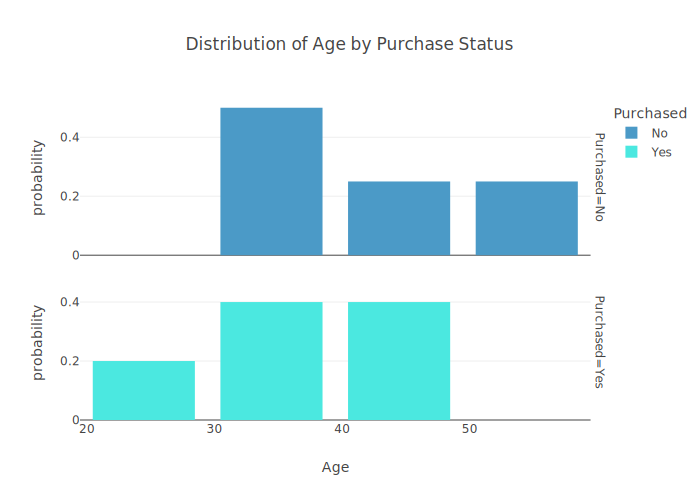

Distribution of Salary:


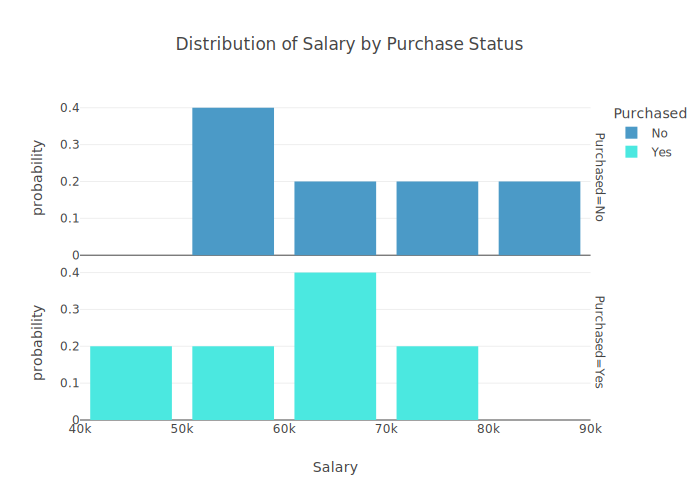

In [23]:
# Univariate Analysis - Distribution of each numeric variable
num_features = ["Age", "Salary"]

# Loop through each numeric feature and plot distribution
for feature in num_features:
    if feature in dataset.columns:
        print(f"Distribution of {feature}:")
        fig = px.histogram(
            dataset,
            x=feature,
            color="Purchased",
            facet_row="Purchased",
            histnorm="probability",
            title=f"Distribution of {feature} by Purchase Status"
        )
        fig.update_layout(bargap=0.2)  # Optional: adjust bar gap for readability
        fig.show()
    else:
        print(f"Feature '{feature}' not found in dataset columns.")

TIP Good to know

As the target variable (Purchased) is categorical, it's not possible to make a scatterplot or to compute a correlation coefficient to test the dependency between the features and the target. The figure above allows to get an hint about which feature carries useful information to predict Y: if the distribution is very different depending on the value of Y, then the variable might be a good predictor of the target!

# Baseline model : simple logistic regression

Let's try a first basic model : simple logistic regression with only one feature (Salary).

In [24]:
# Separate target variable Y from features X
print("Separating labels from features...")

features_list = ["Salary"]
target_variable = "Purchased"

# Vérification que les colonnes existent dans le dataset
if all(feature in dataset.columns for feature in features_list) and target_variable in dataset.columns:
    X = dataset[features_list]
    Y = dataset[target_variable]
    
    print("Separation successful.")
    print("\nTarget variable (Y):")
    print(Y.head())
    print("\nFeatures (X):")
    print(X.head())
else:
    missing_features = [feature for feature in features_list if feature not in dataset.columns]
    if target_variable not in dataset.columns:
        missing_features.append(target_variable)
    print(f"Error: The following columns are missing in the dataset: {missing_features}")

Separating labels from features...
Separation successful.

Target variable (Y):
0     No
1    Yes
2     No
3     No
4    Yes
Name: Purchased, dtype: object

Features (X):
   Salary
0   72000
1   48000
2   54000
3   61000
4   69000


In [25]:
# Divide dataset into Train set & Test set
print("Dividing dataset into train and test sets...")

# Split the dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print("Dataset successfully divided.")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print()

Dividing dataset into train and test sets...
Dataset successfully divided.
Training set size: 8 samples
Test set size: 2 samples



# Preprocessing

NOTE: Simplified syntax

In this first example, we don't need to use the classes Pipeline and ColumnTransformer because the preprocessing on the features X is very simple : it just consists in standardizing the variable Salary (there are no missing values in this column). In this case, we can just create an instance of StandardScaler and call the fit_transform and transform methods directly on it, by passing X_train/X_test as argument.

We'll also make a label encoding on the target Y_train/Y_test, because it's categorical this time 🤓

In [26]:
# Preprocessing X_train with scaling
print("Preprocessing X_train with StandardScaler...")
print("Before scaling:")
print(X_train[:5])
print()

preprocessor = StandardScaler()
X_train = preprocessor.fit_transform(X_train)

print("After scaling (first 5 samples):")
print(X_train[:5, :])  # X_train est maintenant un numpy array
print("...Done!\n")

# Label encoding for Y_train
print("Encoding labels for Y_train...")
print("Original labels (first 5):")
print(Y_train[:5])

encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)

print("Encoded labels (first 5):")
print(Y_train[:5])
print("...Done")

Preprocessing X_train with StandardScaler...
Before scaling:
   Salary
4   69000
9   67000
1   48000
6   52000
7   79000

After scaling (first 5 samples):
[[ 0.58858382]
 [ 0.38385901]
 [-1.56102665]
 [-1.15157703]
 [ 1.61220785]]
...Done!

Encoding labels for Y_train...
Original labels (first 5):
4    Yes
9    Yes
1    Yes
6     No
7    Yes
Name: Purchased, dtype: object
Encoded labels (first 5):
[1 1 1 0 1]
...Done


In [27]:
# Preprocessing X_test with scaling
print("Preprocessing X_test with StandardScaler...")
print("Before scaling (first 5 samples):")
print(X_test[:5])
print()

X_test = preprocessor.transform(X_test)

print("After scaling (first 5 samples):")
print(X_test[:5, :])  # X_test est maintenant un numpy array
print("...Done!\n")

# Label encoding for Y_test
print("Encoding labels for Y_test...")
print("Original labels (first 5):")
print(Y_test[:5])

Y_test = encoder.transform(Y_test)

print("Encoded labels (first 5):")
print(Y_test[:5])
print("...Done")

Preprocessing X_test with StandardScaler...
Before scaling (first 5 samples):
   Salary
2   54000
8   83000

After scaling (first 5 samples):
[[-0.94685223]
 [ 2.02165746]]
...Done!

Encoding labels for Y_test...
Original labels (first 5):
2    No
8    No
Name: Purchased, dtype: object
Encoded labels (first 5):
[0 0]
...Done


# Train model

In [28]:
# Train Logistic Regression model
print("Training Logistic Regression model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("Model training complete.")

Training Logistic Regression model...
Model training complete.


# Performance assessment

In [29]:
# Predictions on training set
print("Generating predictions on the training set...")
Y_train_pred = classifier.predict(X_train)
print("Predictions on training set complete.")
print("Predicted labels:")
print(Y_train_pred)
print()

# Obtaining probabilities estimated by the model
print("Calculating probabilities on the training set...")
Y_train_proba = classifier.predict_proba(X_train)
print("Probability estimates complete.")
print("Predicted probabilities (first 5 samples):")
print(Y_train_proba[:5])  # Affiche les 5 premières probabilités pour une vue d'ensemble
print()

Generating predictions on the training set...
Predictions on training set complete.
Predicted labels:
[1 1 1 1 1 1 1 1]

Calculating probabilities on the training set...
Probability estimates complete.
Predicted probabilities (first 5 samples):
[[0.35108309 0.64891691]
 [0.35903457 0.64096543]
 [0.43790475 0.56209525]
 [0.42089028 0.57910972]
 [0.31261837 0.68738163]]



In [30]:
# Predictions on test set
print("Generating predictions on the test set...")
Y_test_pred = classifier.predict(X_test)
print("Predictions on test set complete.")
print("Predicted labels for test set:")
print(Y_test_pred)
print()

# Obtaining probabilities estimated by the model on test set
print("Calculating probabilities on the test set...")
Y_test_proba = classifier.predict_proba(X_test)
print("Probability estimates complete.")
print("Predicted probabilities (all samples):")
print(Y_test_proba)
print()

Generating predictions on the test set...
Predictions on test set complete.
Predicted labels for test set:
[1 1]

Calculating probabilities on the test set...
Probability estimates complete.
Predicted probabilities (all samples):
[[0.4124504  0.5875496 ]
 [0.29789198 0.70210802]]



In [31]:
# Print accuracy scores
print("Model Performance Metrics:")

train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
print(f"Accuracy on training set: {train_accuracy:.2f}")
print(f"Accuracy on test set: {test_accuracy:.2f}")
print()

# Print F1 scores
train_f1 = f1_score(Y_train, Y_train_pred)
test_f1 = f1_score(Y_test, Y_test_pred)
print(f"F1-score on training set: {train_f1:.2f}")
print(f"F1-score on test set: {test_f1:.2f}")
print()

Model Performance Metrics:
Accuracy on training set: 0.62
Accuracy on test set: 0.00

F1-score on training set: 0.77
F1-score on test set: 0.00



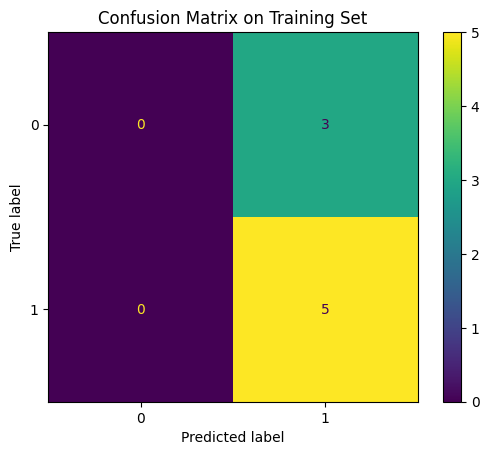

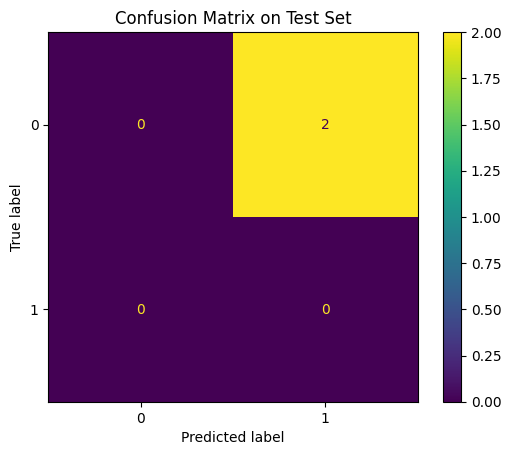

In [32]:
# Visualize confusion matrix for training set
fig, ax = plt.subplots()
ax.set_title("Confusion Matrix on Training Set")
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax)
plt.show()

# Visualize confusion matrix for test set
fig, ax = plt.subplots()
ax.set_title("Confusion Matrix on Test Set")
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax)
plt.show()

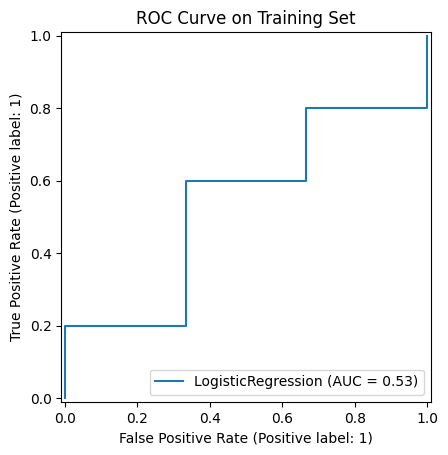

/Users/marie-sophiechenevier/Library/CloudStorage/Dropbox/8-Jedha/GitHub/2-Jedha_Fullstack/.venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



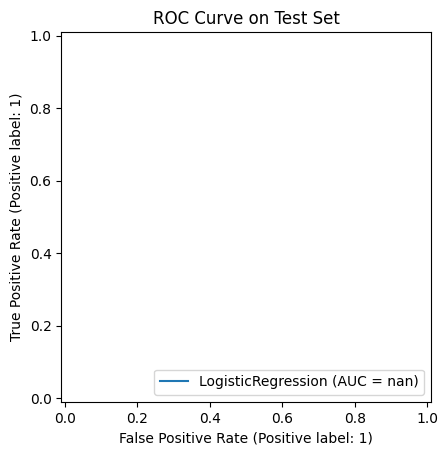

In [33]:
# Visualize ROC curve for training set
fig, ax = plt.subplots()
ax.set_title("ROC Curve on Training Set")
RocCurveDisplay.from_estimator(classifier, X_train, Y_train, ax=ax)
plt.show()

# Visualize ROC curve for test set
fig, ax = plt.subplots()
ax.set_title("ROC Curve on Test Set")
RocCurveDisplay.from_estimator(classifier, X_test, Y_test, ax=ax)
plt.show()

NOTE: Empty plot

The plot above is empty because the ROC curve implies that we have examples belonging to the two classes (0 and 1). However, the test set is very small (there are only two examples) and it contains only 0s. This shouldn't occur while working on datasets with a sufficient number of examples 😌

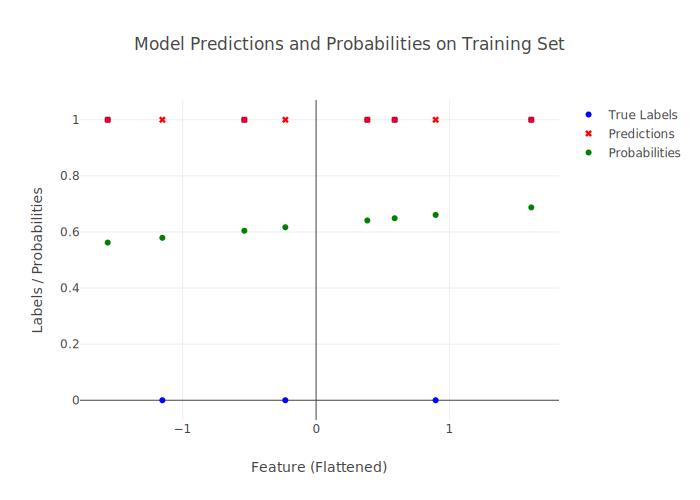

In [34]:
# Visualize predictions on training set
fig = go.Figure()

# Ajout des vraies valeurs (observations)
fig.add_trace(
    go.Scatter(
        x=X_train.flatten(),
        y=Y_train,
        mode="markers",
        name="True Labels",
        marker=dict(color="blue"),
    )
)

# Ajout des prédictions du modèle
fig.add_trace(
    go.Scatter(
        x=X_train.flatten(),
        y=Y_train_pred,
        mode="markers",
        name="Predictions",
        marker=dict(color="red", symbol="x"),
    )
)

# Ajout des probabilités prédictives
fig.add_trace(
    go.Scatter(
        x=X_train.flatten(),
        y=Y_train_proba[:, 1],
        mode="markers",
        name="Probabilities",
        marker=dict(color="green", symbol="circle"),
    )
)

# Paramètres du titre et des axes
fig.update_layout(
    title="Model Predictions and Probabilities on Training Set",
    xaxis_title="Feature (Flattened)",
    yaxis_title="Labels / Probabilities",
)

fig.show()

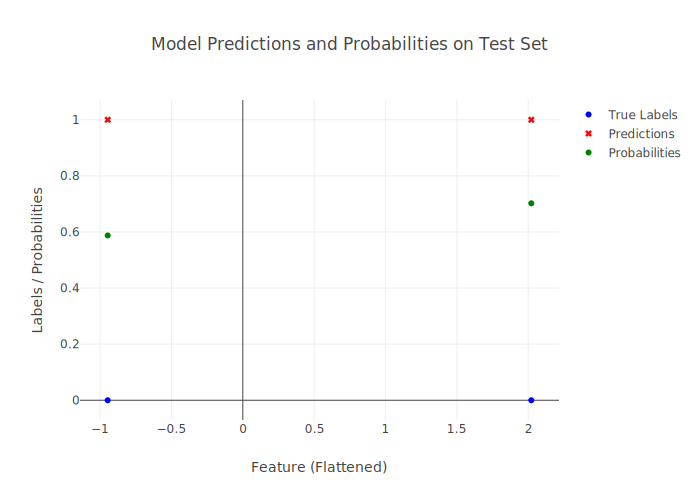

In [35]:
# Visualize predictions on test set
fig = go.Figure()

# Ajout des vraies valeurs (observations)
fig.add_trace(
    go.Scatter(
        x=X_test.flatten(),
        y=Y_test,
        mode="markers",
        name="True Labels",
        marker=dict(color="blue"),
    )
)

# Ajout des prédictions du modèle
fig.add_trace(
    go.Scatter(
        x=X_test.flatten(),
        y=Y_test_pred,
        mode="markers",
        name="Predictions",
        marker=dict(color="red", symbol="x"),
    )
)

# Ajout des probabilités prédictives
fig.add_trace(
    go.Scatter(
        x=X_test.flatten(),
        y=Y_test_proba[:, 1],
        mode="markers",
        name="Probabilities",
        marker=dict(color="green", symbol="circle"),
    )
)

# Configuration du layout
fig.update_layout(
    title="Model Predictions and Probabilities on Test Set",
    xaxis_title="Feature (Flattened)",
    yaxis_title="Labels / Probabilities",
)

fig.show()

# Multivariate logistic regression

Let's train a multivariate model with 3 variables: Age, Country and Salary.

In [36]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "Purchased"

X = dataset.drop(columns=[target_variable])
Y = dataset[target_variable]

print("...Done.")
print()

print("Y (Target variable):")
print(Y.head())
print("\nX (Features):")
print(X.head())

Separating labels from features...
...Done.

Y (Target variable):
0     No
1    Yes
2     No
3     No
4    Yes
Name: Purchased, dtype: object

X (Features):
   Country   Age  Salary
0   France  44.0   72000
1    Spain  27.0   48000
2  Germany  30.0   54000
3    Spain  38.0   61000
4  Germany  40.0   69000


In [37]:
# Automatically detect names of numeric and categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("Found numeric features:", numeric_features)
print("Found categorical features:", categorical_features)

Found numeric features: ['Age', 'Salary']
Found categorical features: ['Country']


In [38]:
# Divide dataset into Train and Test sets
print("Dividing dataset into train and test sets...")
# Using stratify=Y to ensure balanced class distribution in both sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0, stratify=Y
)
print("Dataset division complete.")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print()

Dividing dataset into train and test sets...
Dataset division complete.
Training set size: 8 samples
Test set size: 2 samples



# Preprocessing

In [ ]:
# Pipeline for processing numeric features
numeric_transformer = Pipeline(
    steps=[
        # Impute missing values with the mean of each column
        ("imputer", SimpleImputer(strategy="mean")),
        # Scale features to have mean 0 and variance 1
        ("scaler", StandardScaler())
    ]
)

In [40]:
# Pipeline for processing categorical features
categorical_transformer = OneHotEncoder(drop="first")  # Apply One-Hot Encoding and drop the first category to avoid multicollinearity

In [41]:
# Define a ColumnTransformer to preprocess both numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),  # Apply numeric transformations
        ("cat", categorical_transformer, categorical_features)  # Apply categorical transformations
    ]
)

In [42]:
# Preprocessings on training set
print("Performing preprocessing on training set...")
print("First 5 rows before preprocessing:")
print(X_train.head())

X_train = preprocessor.fit_transform(X_train)
print("Preprocessing complete.")
print("First 5 rows after preprocessing:")
print(X_train[:5])  # Utilisation de la syntaxe numpy car X_train est maintenant un numpy array
print()

# Label encoding for Y_train
print("Encoding labels for training set...")
print("Original labels (first 5):")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("Encoded labels (first 5):")
print(Y_train[:5])
print("...Done\n")

# Preprocessings on test set
print("Performing preprocessing on test set...")
print("First 5 rows before preprocessing:")
print(X_test.head())

# Only transform on the test set, no fitting
X_test = preprocessor.transform(X_test)
print("Preprocessing complete.")
print("First 5 rows after preprocessing:")
print(X_test[:5, :])
print()

# Label encoding for Y_test
print("Encoding labels for test set...")
print("Original labels (first 5):")
print(Y_test.head())
Y_test = encoder.transform(Y_test)
print("Encoded labels (first 5):")
print(Y_test[:5])
print("...Done")

Performing preprocessing on training set...
First 5 rows before preprocessing:
   Country   Age  Salary
0   France  44.0   72000
4  Germany  40.0   69000
6    Spain   NaN   52000
9   France  37.0   67000
3    Spain  38.0   61000
Preprocessing complete.
First 5 rows after preprocessing:
[[ 1.61706195e+00  1.46885753e+00  0.00000000e+00  0.00000000e+00]
 [ 8.22715727e-01  1.09777773e+00  1.00000000e+00  0.00000000e+00]
 [-1.41104234e-15 -1.00500778e+00  0.00000000e+00  1.00000000e+00]
 [ 2.26956063e-01  8.50391200e-01  0.00000000e+00  0.00000000e+00]
 [ 4.25542617e-01  1.08231607e-01  0.00000000e+00  1.00000000e+00]]

Encoding labels for training set...
Original labels (first 5):
0     No
4    Yes
6     No
9    Yes
3     No
Name: Purchased, dtype: object
Encoded labels (first 5):
[0 1 0 1 0]
...Done

Performing preprocessing on test set...
First 5 rows before preprocessing:
   Country   Age  Salary
8  Germany  50.0   83000
7   France  48.0   79000
Preprocessing complete.
First 5 rows aft

# Train model

In [43]:
# Train Logistic Regression model
print("Training Logistic Regression model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("Model training complete.")

Training Logistic Regression model...
Model training complete.


# Performance assessment

In [44]:
# Predictions on training set
print("Generating predictions on the training set...")
Y_train_pred = classifier.predict(X_train)
print("Predictions on training set complete.")
print("Predicted labels:")
print(Y_train_pred)
print()

# Obtaining probabilities estimated by the model
print("Calculating probabilities on the training set...")
Y_train_proba = classifier.predict_proba(X_train)
print("Probability estimates complete.")
print("Predicted probabilities (first 5 samples):")
print(Y_train_proba[:5])  # Affiche les 5 premières probabilités pour une vue d'ensemble
print()

Generating predictions on the training set...
Predictions on training set complete.
Predicted labels:
[0 0 0 1 0 1 1 1]

Calculating probabilities on the training set...
Probability estimates complete.
Predicted probabilities (first 5 samples):
[[0.55879136 0.44120864]
 [0.50928583 0.49071417]
 [0.6207777  0.3792223 ]
 [0.42793959 0.57206041]
 [0.59398603 0.40601397]]



In [45]:
# Predictions on test set
print("Generating predictions on the test set...")
Y_test_pred = classifier.predict(X_test)
print("Predictions on test set complete.")
print("Predicted labels for test set:")
print(Y_test_pred)
print()

# Obtaining probabilities estimated by the model on test set
print("Calculating probabilities on the test set...")
Y_test_proba = classifier.predict_proba(X_test)
print("Probability estimates complete.")
print("Predicted probabilities (all samples):")
print(Y_test_proba)
print()

Generating predictions on the test set...
Predictions on test set complete.
Predicted labels for test set:
[0 0]

Calculating probabilities on the test set...
Probability estimates complete.
Predicted probabilities (all samples):
[[0.63138923 0.36861077]
 [0.59517426 0.40482574]]



In [46]:
# Print accuracy scores
print("Model Performance Metrics:")

train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
print(f"Accuracy on training set: {train_accuracy:.2f}")
print(f"Accuracy on test set: {test_accuracy:.2f}")
print()

# Print F1 scores
train_f1 = f1_score(Y_train, Y_train_pred)
test_f1 = f1_score(Y_test, Y_test_pred)
print(f"F1-score on training set: {train_f1:.2f}")
print(f"F1-score on test set: {test_f1:.2f}")
print()

Model Performance Metrics:
Accuracy on training set: 0.75
Accuracy on test set: 0.50

F1-score on training set: 0.75
F1-score on test set: 0.00



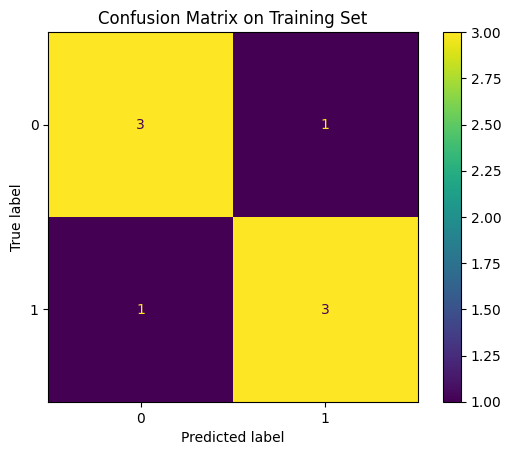

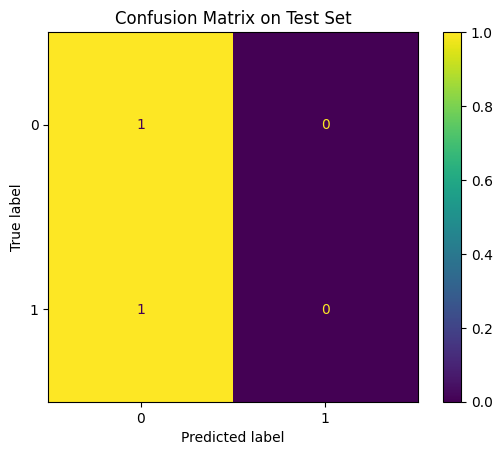

In [47]:
# Visualize confusion matrix for training set
fig, ax = plt.subplots()
ax.set_title("Confusion Matrix on Training Set")
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax)
plt.show()

# Visualize confusion matrix for test set
fig, ax = plt.subplots()
ax.set_title("Confusion Matrix on Test Set")
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax)
plt.show()

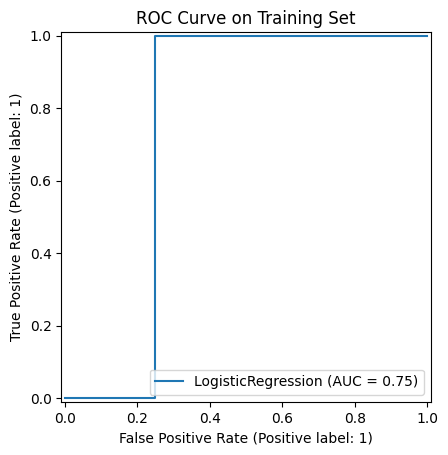

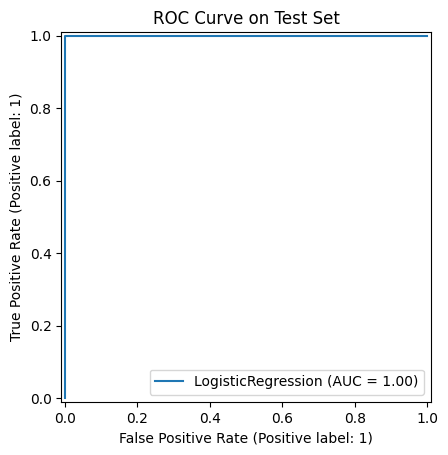

In [48]:
# Visualize ROC curve for training set
fig, ax = plt.subplots()
ax.set_title("ROC Curve on Training Set")
RocCurveDisplay.from_estimator(classifier, X_train, Y_train, ax=ax)
plt.show()

# Visualize ROC curve for test set
fig, ax = plt.subplots()
ax.set_title("ROC Curve on Test Set")
RocCurveDisplay.from_estimator(classifier, X_test, Y_test, ax=ax)
plt.show()